In [94]:
import polars as pl
import numpy as np
import torch.utils.data
import torch
import torch.nn as nn
import lightning
import lightning.pytorch
import random
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
scan = pl.scan_parquet("../../fishnet-position-dataset/endgame_evals.parquet")

In [3]:
scan.group_by("piece_count").len().sort("len").collect()

piece_count,len
u8,u32
2,1850480
3,118569229
4,173072838
5,212005402
6,254848650
7,297170292
8,343192392


In [110]:
scan.filter(pl.col("piece_count") == 8).group_by("op1").len().collect()

op1,len
bool,u32
false,152134204
true,191058188


In [123]:
plot_data = scan.filter(pl.col("piece_count") > 2).group_by("piece_count", "op1").len().sort("piece_count", "op1").collect()

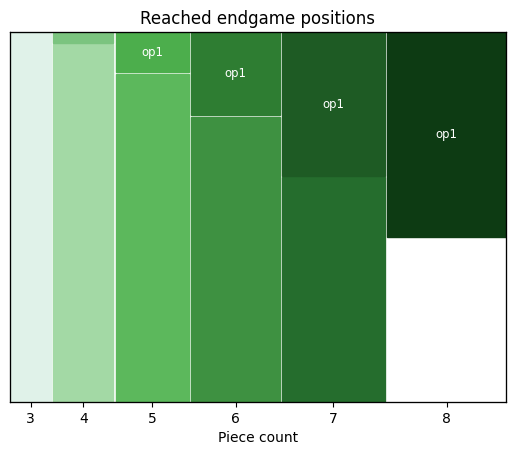

In [185]:
d = {}
for piece_count, op1, count in plot_data.iter_rows():
    d[(piece_count, op1)] = count

def labelizer(k):
    piece_count, op1 = k
    piece_count = int(piece_count)
    op1 = op1 == "True"
    return "op1" if (op1 and int(piece_count) > 4) else ""

GREENS = [
    "#e0f2e9",  # Mint Frost
    "#c1e1c1",  # Tea Green
    "#a3d9a5",  # Granny Smith
    "#7bc47f",  # Mantis
    "#5cb85c",  # Medium Green
    "#4cae4c",  # Shamrock
    "#3e9141",  # Forest Green
    "#2e7d32",  # Verdant
    "#256d2d",  # Dark Olive
    "#1e5b24",  # Pine
    "#144d1a",  # Deep Green
    "#0d3b13",  # Black Forest (extra deep green)
]

def properties(k):
    piece_count, op1 = k
    piece_count = int(piece_count)
    op1 = op1 == "True"
    return {
        "color": GREENS[2 * (piece_count - 3) + op1] if piece_count < 8 or op1 else "white",
        #"label_props": {"color": "white"}
    }

fig, _ = mosaic(d, labelizer=labelizer, properties=properties, title="Reached endgame positions")
ax = fig.get_axes()[0]
ax.set_xlabel("Piece count")
ax.get_yaxis().set_visible(False)
for text in ax.texts:
    text.set_color("white")
plt.show()

In [34]:
DIM = 14 * 64 + 1
HIDDEN_DIM = 0

PIECE_TO_PLANE = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11,
}

PIECE_VALUE = {
    'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0,
    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k': 0,
}

def fen_to_onehot(fen):
    board, turn, ep, _ = fen.split(" ", 3)
    tensor = torch.zeros(DIM + HIDDEN_DIM, dtype=torch.float32)
    x = 0
    material_balance = 0
    for ch in board:
        if ch.isdigit():
            x += int(ch)
        elif ch == "/":
            continue
        else:
            tensor[64 * PIECE_TO_PLANE[ch] + (x ^ 0x38)] = 1
            material_balance += PIECE_VALUE[ch]
            x += 1
    if ep != "-":
        x = (ord(ep[0]) - ord("a")) * 8 + (ord(ep[1]) - ord("1"))
        tensor[64 * (12 if turn == "w" else 13) + x] = 1
    tensor[DIM - 1] = int(turn == "w")
    #tensor[DIM] = material_balance
    return tensor

In [35]:
fen_to_onehot("4k3/8/8/8/8/8/8/R3K3 w - - 0 1")

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [8]:
df = scan.filter(
    pl.col("piece_count").eq(8) &
    pl.col("op1") &
    pl.col("cp").abs().gt(50).fill_null(True)
).select(
    pl.col("fen"),
    (pl.col("cp").fill_null(0).gt(0) | pl.col("mate").fill_null(0).gt(0)).alias("win")
).collect()

In [9]:
df

fen,win
str,bool
"""r5k1/5p1p/4p3/8/8/4K1P1/7P/8 b…",false
"""6k1/5p1p/4p3/8/8/4K1P1/r6P/8 w…",false
"""6k1/5p1p/4p3/8/5K2/6P1/r6P/8 b…",false
"""8/7R/1Pp3p1/1nP2k2/2K5/8/8/8 b…",true
"""8/7R/1Pp5/1nP2kp1/2K5/8/8/8 w …",true
…,…
"""8/8/8/5p2/5p1p/1kp4P/p7/1K6 w …",false
"""8/8/8/5p2/5p1p/1kp4P/p7/K7 b -…",false
"""8/8/8/5p2/2k2p1p/2p4P/p7/K7 w …",false


In [36]:
class EndgameDataset(torch.utils.data.IterableDataset):
    def __init__(self, df, shuffle=False):
        self.df = df
        self.shuffle = shuffle

    def __len__(self):
        return len(self.df)

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:
            # Single-process data loading
            start = 0
            end = len(self.df)
        else:
            # In a worker process
            per_worker = len(self.df) // worker_info.num_workers
            worker_id = worker_info.id
            start = worker_id * per_worker
            end = start + per_worker if worker_id != worker_info.num_workers - 1 else len(self.df)

        # Only iterate over your slice
        for sub in self.df[start:end].iter_slices(512):
            rows = [
                (fen_to_onehot(row[0]), torch.tensor(row[1], dtype=torch.float32))
                for row in sub.iter_rows()
            ]
            if self.shuffle:
                random.shuffle(rows)
            yield from rows

In [37]:
val_dataset = EndgameDataset(df.slice(0, 100_000))
train_dataset = EndgameDataset(df.slice(100_000), shuffle=True)

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512 * 20, num_workers=31)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512 * 2, num_workers=10)

In [41]:
def baseline():
    def material_count_predict_batch(inputs):
        return (inputs[:, DIM] >= 0).clone().detach().unsqueeze(1)
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            preds = material_count_predict_batch(inputs)
            correct += (preds.squeeze() == labels).sum().item()
            total += len(labels)
    
    accuracy = correct / total
    print(f"Material count prediction acc: {accuracy:.4f}")  # ~90%

In [42]:
class SmallEndgameNet(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(DIM, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y.unsqueeze(1)).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [46]:
small_model = SmallEndgameNet()
trainer = lightning.pytorch.Trainer(max_epochs=1, limit_train_batches=1.0, accelerator="auto")
trainer.fit(small_model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Sequential        | 29.8 K | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
29.8 K    Trainable params
0         Non-trainable params
29.8 K    Total params
0.119     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


In [44]:
class LargeEndgameNet(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LayerNorm(DIM),

            nn.Linear(DIM, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 1)
        )
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y.unsqueeze(1)).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [45]:
large_model = LargeEndgameNet()
trainer = lightning.pytorch.Trainer(max_epochs=1, limit_train_batches=1.0, accelerator="auto")
trainer.fit(large_model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Sequential        | 1.6 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.442     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


In [47]:
class NarrowEndgameNet(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(DIM, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1).float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y.unsqueeze(1)).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [48]:
narrow_model = NarrowEndgameNet()
trainer = lightning.pytorch.Trainer(max_epochs=1, limit_train_batches=1.0, accelerator="auto")
trainer.fit(narrow_model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Sequential        | 30.5 K | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
30.5 K    Trainable params
0         Non-trainable params
30.5 K    Total params
0.122     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.
